In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from func import *
from torch.utils.data import random_split, TensorDataset
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
datos = pd.read_csv("Churn_Modelling.csv")
datos.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [25]:
# Separamos la ultima columna para que sea variable destino
datos_y = datos[datos.columns[-1]]

# Eliminamos las columnas que no funcionarán
datos_x = datos.drop(columns=["RowNumber", "CustomerId", "Surname", "Exited"])

# Convertimos en one hot encoding las columnas de genero y zona geográfica
datos_x = pd.get_dummies(datos_x)

In [26]:
escalador = StandardScaler()
datos_x = escalador.fit_transform(datos_x)

## train test split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size = 0.2, random_state = 2)

In [28]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
n_entradas = X_train.shape[1]

X Train: (8000, 13), X Test: (2000, 13), y_train: (8000,), y_test: (2000,)


## to tensor

In [29]:
t_X_train = torch.from_numpy(X_train).float().to("cpu") #MPS
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]
test = TensorDataset(t_X_test, t_y_test)

In [30]:
%%time
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=13, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=200, bias=True)
  (linear5): Linear(in_features=200, out_features=8, bias=True)
  (linear6): Linear(in_features=8, out_features=1, bias=True)
)
Entranando el modelo



Epoch 100 	 Loss: 0.5796
Accuracy: 80.8499984741211

Epoch 200 	 Loss: 0.5541
Accuracy: 80.8499984741211

Epoch 300 	 Loss: 0.537
Accuracy: 80.8499984741211

Epoch 400 	 Loss: 0.5258
Accuracy: 80.8499984741211

Epoch 500 	 Loss: 0.5189
Accuracy: 80.8499984741211

Epoch 600 	 Loss: 0.5147
Accuracy: 80.8499984741211

Epoch 700 	 Loss: 0.5123
Accuracy: 80.8499984741211

Epoch 800 	 Loss: 0.5099
Accuracy: 80.8499984741211

Epoch 900 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 1000 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 1100 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 1200 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 1300 	 Loss: 0.5096
Accuracy: 80.8499984741211

Epoch 1400 	 Loss: 0.509
Accuracy: 80.8499984741211

Epoch 1500 	 Loss: 0.4854
Accuracy: 80.8499984741211

Epoch 1600 	 Loss: 0.4697
Accuracy: 80.8499984741211

Epoch 1700 	 Loss: 0.4359
Accuracy: 80.8499984741211

Epoch 1800 	 Loss: 0.4264
Accuracy: 80.8499984741211

Epoch 1900 	 Loss: 0.4065
Accuracy: 81

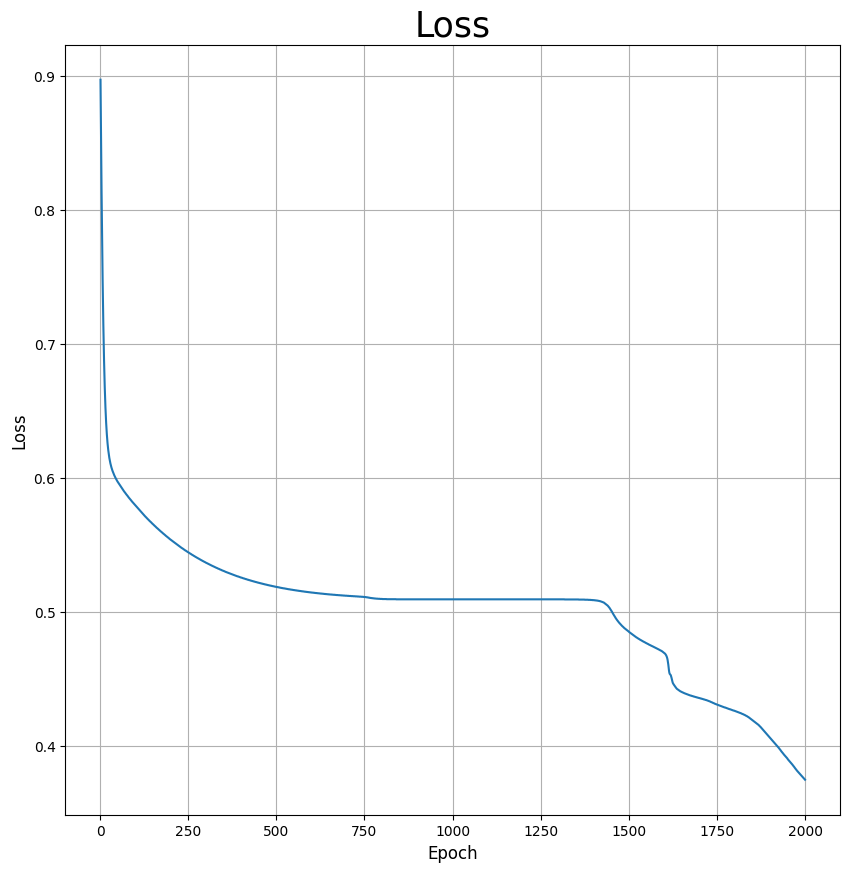

In [31]:



plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()



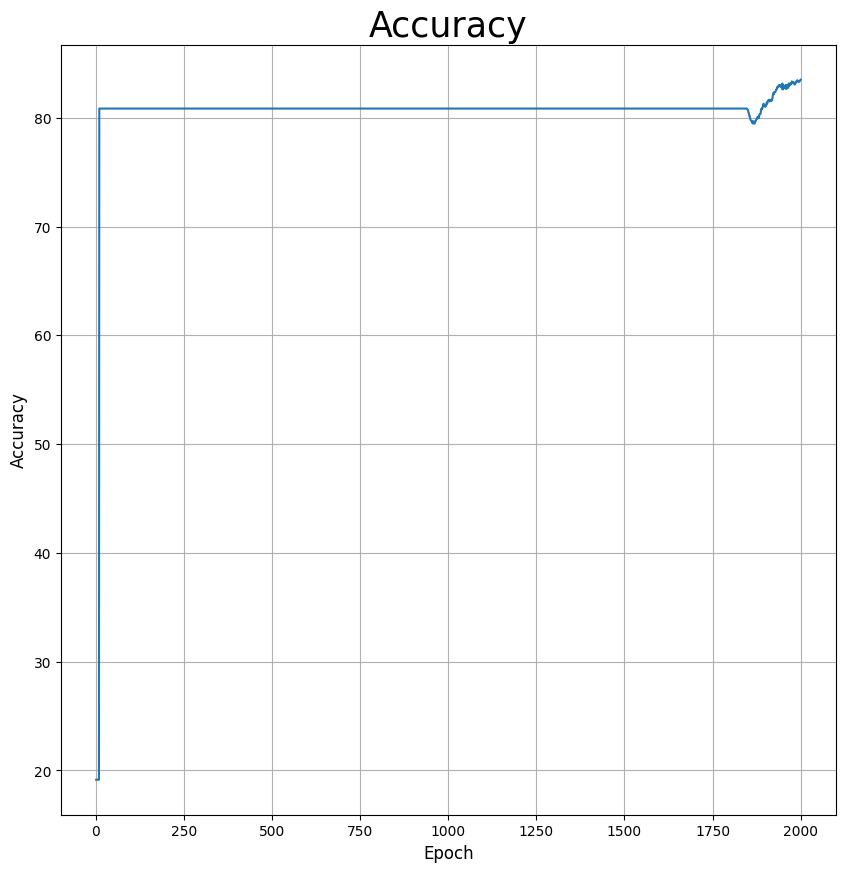

In [32]:


plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()



In [33]:


prediccion = model(t_X_test[5])
print(prediccion)



tensor([0.0856], grad_fn=<SigmoidBackward0>)
